In [1]:
pip install cartopy matplotlib pandas

Note: you may need to restart the kernel to use updated packages.


Total PV potential in Yunlin County: 12445.21 MW


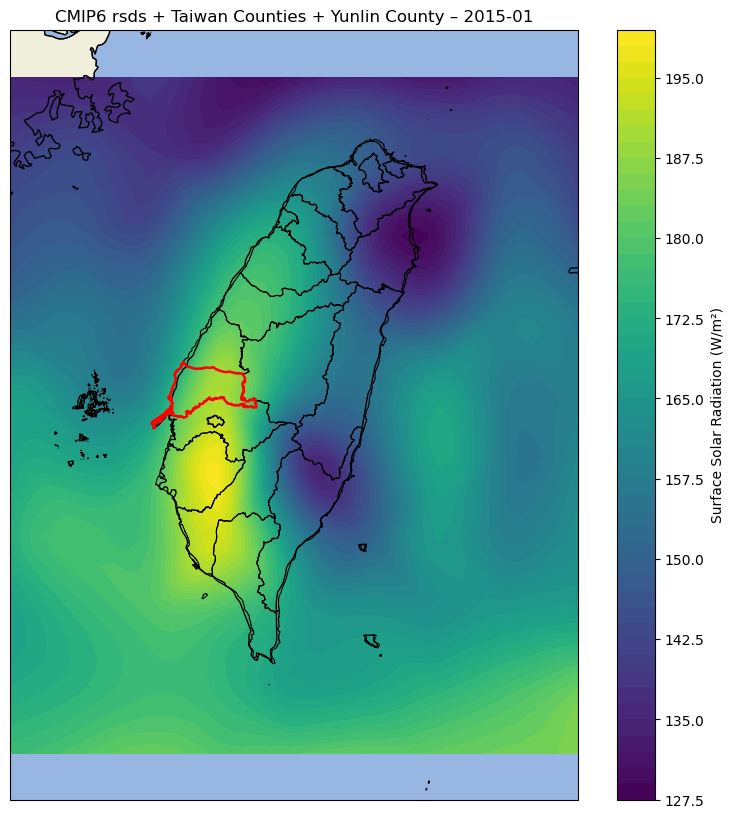

In [1]:
# ======================================
# CMIP6 rsds contour + Taiwan county boundaries + PV potential calculation
# ======================================

import pandas as pd
import numpy as np
import numpy.ma as ma
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from shapely.geometry import Point
from pyproj import Geod
from scipy.interpolate import griddata

# --------------------------------------
# 1. Load CMIP6 data
# --------------------------------------
df = pd.read_csv(r"C:\Users\User\Downloads\rsds_radiation_CNRM_CM6_1_HR_ssp585_2015_2099_new.csv")
df.columns = df.columns.str.strip()
df["time"] = pd.to_datetime(df["time"])

# Filter for specific month
target_month = "2015-01"
df_month = df[df["time"].dt.strftime("%Y-%m") == target_month]

# --------------------------------------
# 2. Interpolate data onto grid
# --------------------------------------
num_points = 50
lon_grid = np.linspace(119, 123, num_points)
lat_grid = np.linspace(21, 26, num_points)
lon2d, lat2d = np.meshgrid(lon_grid, lat_grid)

points = df_month[["lon", "lat"]].values
values = df_month["rsds"].values
grid_rsds = griddata(points, values, (lon2d, lat2d), method='cubic')

# Mask invalid values
masked_rsds = ma.masked_invalid(grid_rsds)

# --------------------------------------
# 3. Load county shapefile
# --------------------------------------
county_file_path = r"C:\Users\User\Downloads\直轄市、縣(市)界線1140318\COUNTY_MOI_1140318.shp"
gdf_county = gpd.read_file(county_file_path)

# Reproject to EPSG:4326 if needed
if gdf_county.crs.to_string() != 'EPSG:4326':
    gdf_county = gdf_county.to_crs(epsg=4326)

# --------------------------------------
# 4. Select target county for PV calculation
# --------------------------------------
target_county = '雲林縣'
county_row = gdf_county[gdf_county['COUNTYNAME'] == target_county]

if county_row.empty:
    raise ValueError("Target county not found in shapefile. Check spelling or field names.")

county_geom = county_row.geometry.iloc[0]
target_county_eng = county_row['COUNTYENG'].iloc[0]

# --------------------------------------
# 5. Calculate grid cell areas
# --------------------------------------
geod = Geod(ellps="WGS84")
cell_areas = np.zeros(lon2d.shape)

for i in range(len(lat_grid)-1):
    for j in range(len(lon_grid)-1):
        lons = [lon2d[i,j], lon2d[i,j+1], lon2d[i+1,j+1], lon2d[i+1,j]]
        lats = [lat2d[i,j], lat2d[i,j+1], lat2d[i+1,j+1], lat2d[i+1,j]]
        poly_area, _ = geod.polygon_area_perimeter(lons, lats)
        cell_areas[i,j] = abs(poly_area)  # area in m²

# --------------------------------------
# 6. Calculate total PV potential within county
# --------------------------------------
efficiency = 0.15
panel_ratio = 0.3
total_potential = 0

for i in range(len(lat_grid)):
    for j in range(len(lon_grid)):
        if masked_rsds[i,j] is ma.masked:
            continue
        point = Point(lon2d[i,j], lat2d[i,j])
        if county_geom.contains(point):
            rsds = masked_rsds[i,j]  # W/m²
            area = cell_areas[i,j]   # m²
            potential = rsds * area * efficiency * panel_ratio  # W
            total_potential += potential

# Convert to MW
total_potential_MW = total_potential / 1e6
print(f"Total PV potential in {target_county_eng}: {total_potential_MW:.2f} MW")

# --------------------------------------
# 7. Plotting combined contour + county boundaries
# --------------------------------------
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection=ccrs.Mercator())
ax.set_extent([119, 123, 21, 26], crs=ccrs.PlateCarree())

# Base map features
ax.coastlines(resolution='10m')
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, edgecolor='black')
ax.add_feature(cfeature.OCEAN)

# CMIP6 rsds contour
cf = ax.contourf(
    lon2d, lat2d, masked_rsds, 60,
    transform=ccrs.PlateCarree(), cmap="viridis"
)

# County boundaries overlay
for _, row in gdf_county.iterrows():
    geom = row.geometry
    ax.add_geometries([geom], crs=ccrs.PlateCarree(),
                      edgecolor='black', facecolor='none', linewidth=0.8)

# Highlight target county in red
ax.add_geometries([county_geom], crs=ccrs.PlateCarree(),
                  edgecolor='red', facecolor='none', linewidth=1.8)

# Colorbar and title
plt.colorbar(cf, ax=ax, orientation='vertical', label="Surface Solar Radiation (W/m²)")
plt.title(f"CMIP6 rsds + Taiwan Counties + {target_county_eng} – {target_month}")
plt.show()


Total PV potential in Yunlin County [ssp2]: 16580.06 MW


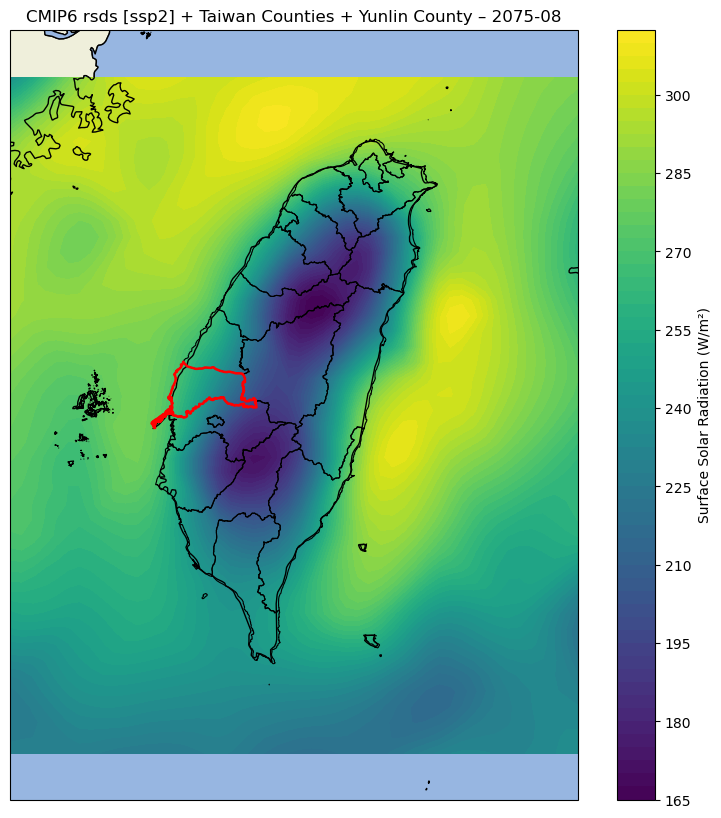

In [23]:
# ======================================
# CMIP6 rsds contour + Taiwan county boundaries + PV potential calculation (final clean version)
# ======================================

import pandas as pd
import numpy as np
import numpy.ma as ma
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from shapely.geometry import Point
from pyproj import Geod
from scipy.interpolate import griddata

# --------------------------------------
# 0. User selection: SSP model and target month
# --------------------------------------
ssp_target = 'ssp2'  # choose from 'ssp2', 'ssp3', 'ssp5'
target_month = '2075-08'
target_county = '雲林縣'

# Map to column name in your dataset
ssp_map = {
    'ssp2': 'rsds_ssp2',
    'ssp3': 'rsds_ssp3',
    'ssp5': 'rsds_ssp5'
}
rsds_col = ssp_map[ssp_target]

# --------------------------------------
# 1. Load CMIP6 data
# --------------------------------------
df = pd.read_csv(r"C:\Users\User\Downloads\cmip6_rsds_cnrmfull.csv")
df.columns = df.columns.str.strip()
df["time"] = pd.to_datetime(df["time"])

# Filter for specific month
df_month = df[df["time"].dt.strftime("%Y-%m") == target_month][["lon", "lat", rsds_col]].copy()
df_month = df_month.rename(columns={rsds_col: "rsds"})

# --------------------------------------
# 2. Interpolate data onto grid
# --------------------------------------
num_points = 50
lon_grid = np.linspace(119, 123, num_points)
lat_grid = np.linspace(21, 26, num_points)
lon2d, lat2d = np.meshgrid(lon_grid, lat_grid)

points = df_month[["lon", "lat"]].values
values = df_month["rsds"].values
grid_rsds = griddata(points, values, (lon2d, lat2d), method='cubic')

# Mask invalid values
masked_rsds = ma.masked_invalid(grid_rsds)

# --------------------------------------
# 3. Load county shapefile
# --------------------------------------
county_file_path = r"C:\Users\User\Downloads\直轄市、縣(市)界線1140318\COUNTY_MOI_1140318.shp"
gdf_county = gpd.read_file(county_file_path)

# Reproject to EPSG:4326 if needed
if gdf_county.crs.to_string() != 'EPSG:4326':
    gdf_county = gdf_county.to_crs(epsg=4326)

# --------------------------------------
# 4. Select target county for PV calculation
# --------------------------------------
county_row = gdf_county[gdf_county['COUNTYNAME'] == target_county]

if county_row.empty:
    raise ValueError("Target county not found in shapefile. Check spelling or field names.")

county_geom = county_row.geometry.iloc[0]
target_county_eng = county_row['COUNTYENG'].iloc[0]

# --------------------------------------
# 5. Calculate grid cell areas
# --------------------------------------
geod = Geod(ellps="WGS84")
cell_areas = np.zeros(lon2d.shape)

for i in range(len(lat_grid)-1):
    for j in range(len(lon_grid)-1):
        lons = [lon2d[i,j], lon2d[i,j+1], lon2d[i+1,j+1], lon2d[i+1,j]]
        lats = [lat2d[i,j], lat2d[i,j+1], lat2d[i+1,j+1], lat2d[i+1,j]]
        poly_area, _ = geod.polygon_area_perimeter(lons, lats)
        cell_areas[i,j] = abs(poly_area)  # area in m²

# --------------------------------------
# 6. Calculate total PV potential within county
# --------------------------------------
efficiency = 0.15
panel_ratio = 0.3
total_potential = 0

for i in range(len(lat_grid)):
    for j in range(len(lon_grid)):
        if masked_rsds[i,j] is ma.masked:
            continue
        point = Point(lon2d[i,j], lat2d[i,j])
        if county_geom.contains(point):
            rsds = masked_rsds[i,j]  # W/m²
            area = cell_areas[i,j]   # m²
            potential = rsds * area * efficiency * panel_ratio  # W
            total_potential += potential

# Convert to MW
total_potential_MW = total_potential / 1e6
print(f"Total PV potential in {target_county_eng} [{ssp_target}]: {total_potential_MW:.2f} MW")

# --------------------------------------
# 7. Plotting combined contour + county boundaries
# --------------------------------------
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection=ccrs.Mercator())
ax.set_extent([119, 123, 21, 26], crs=ccrs.PlateCarree())

# Base map features
ax.coastlines(resolution='10m')
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, edgecolor='black')
ax.add_feature(cfeature.OCEAN)

# CMIP6 rsds contour
cf = ax.contourf(
    lon2d, lat2d, masked_rsds, 60,
    transform=ccrs.PlateCarree(), cmap="viridis"
)

# County boundaries overlay
for _, row in gdf_county.iterrows():
    geom = row.geometry
    ax.add_geometries([geom], crs=ccrs.PlateCarree(),
                      edgecolor='black', facecolor='none', linewidth=0.8)

# Highlight target county in red
ax.add_geometries([county_geom], crs=ccrs.PlateCarree(),
                  edgecolor='red', facecolor='none', linewidth=1.8)

# Colorbar and title
plt.colorbar(cf, ax=ax, orientation='vertical', label="Surface Solar Radiation (W/m²)")
plt.title(f"CMIP6 rsds [{ssp_target}] + Taiwan Counties + {target_county_eng} – {target_month}")
plt.show()


In [21]:
# Check how many grid points land within 嘉義市
city_geom = gdf_county[gdf_county['COUNTYNAME']=='嘉義市'].geometry.iloc[0]

points_in_city = []

for i in range(len(lat_grid)):
    for j in range(len(lon_grid)):
        point = Point(lon2d[i,j], lat2d[i,j])
        if city_geom.contains(point):
            points_in_city.append((lon2d[i,j], lat2d[i,j]))

print(f"Number of grid points within 嘉義市: {len(points_in_city)}")


Number of grid points within 嘉義市: 72


            County_EN         PV_MW
16     Hualien County  44296.951747
15     Taitung County  36338.515661
3       Nantou County  33196.952940
5     Pingtung County  31108.847385
14     Kaohsiung City  26640.590065
8     New Taipei City  21964.015377
9         Tainan City  21349.620848
19      Taichung City  20592.060219
1        Yilan County  20237.186986
12      Chiayi County  19361.219173
20      Miaoli County  17154.997045
4       Yunlin County  16108.398854
2     Changhua County  13441.087427
21     Hsinchu County  12744.203508
10       Taoyuan City  12124.882601
7         Taipei City   2092.238494
17      Penghu County   1136.981991
6        Keelung City   1067.371166
18       Hsinchu City   1000.731848
0   Lienchiang County      0.000000
13      Kinmen County      0.000000
11        Chiayi City      0.000000


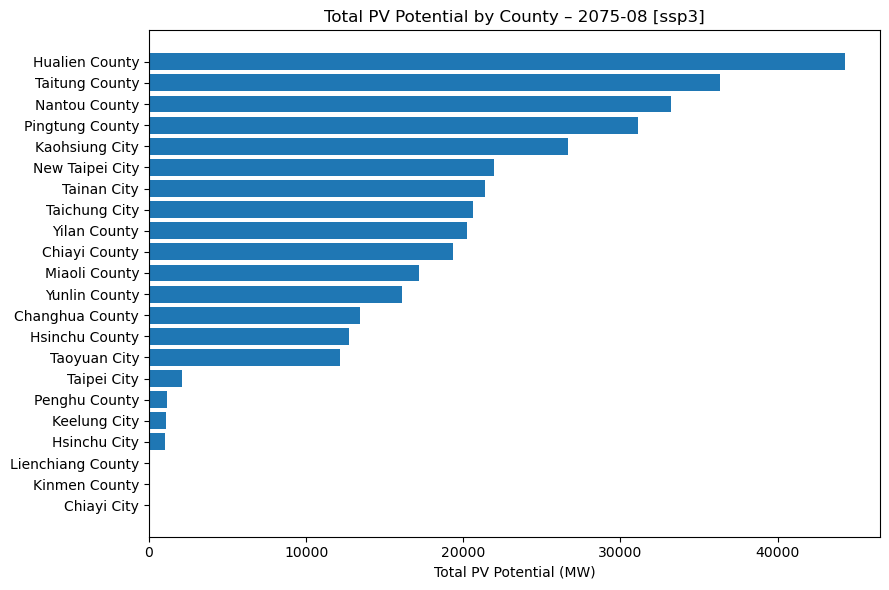

In [36]:
# ======================================
# CMIP6 rsds + Taiwan counties PV potential calculation (bar chart with English labels)
# ======================================

import pandas as pd
import numpy as np
import numpy.ma as ma
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
from pyproj import Geod
from scipy.interpolate import griddata

# --------------------------------------
# 0. User selection: SSP model and target month
# --------------------------------------
ssp_target = 'ssp3'  # choose from 'ssp2', 'ssp3', 'ssp5'
target_month = '2075-08'

# Map to column name in your dataset
ssp_map = {
    'ssp2': 'rsds_ssp2',
    'ssp3': 'rsds_ssp3',
    'ssp5': 'rsds_ssp5'
}
rsds_col = ssp_map[ssp_target]

# --------------------------------------
# 1. Load CMIP6 data
# --------------------------------------
df = pd.read_csv(r"C:\Users\User\Downloads\cmip6_rsds_cnrmfull.csv")
df.columns = df.columns.str.strip()
df["time"] = pd.to_datetime(df["time"])

# Filter for specific month
df_month = df[df["time"].dt.strftime("%Y-%m") == target_month][["lon", "lat", rsds_col]].copy()
df_month = df_month.rename(columns={rsds_col: "rsds"})

# --------------------------------------
# 2. Interpolate data onto grid
# --------------------------------------
num_points = 50
lon_grid = np.linspace(119, 123, num_points)
lat_grid = np.linspace(21, 26, num_points)
lon2d, lat2d = np.meshgrid(lon_grid, lat_grid)

points = df_month[["lon", "lat"]].values
values = df_month["rsds"].values
grid_rsds = griddata(points, values, (lon2d, lat2d), method='cubic')

# Mask invalid values
masked_rsds = ma.masked_invalid(grid_rsds)

# --------------------------------------
# 3. Load county shapefile
# --------------------------------------
county_file_path = r"C:\Users\User\Downloads\直轄市、縣(市)界線1140318\COUNTY_MOI_1140318.shp"
gdf_county = gpd.read_file(county_file_path)

# Reproject to EPSG:4326 if needed
if gdf_county.crs.to_string() != 'EPSG:4326':
    gdf_county = gdf_county.to_crs(epsg=4326)

# --------------------------------------
# 4. Calculate grid cell areas
# --------------------------------------
geod = Geod(ellps="WGS84")
cell_areas = np.zeros(lon2d.shape)

for i in range(len(lat_grid)-1):
    for j in range(len(lon_grid)-1):
        lons = [lon2d[i,j], lon2d[i,j+1], lon2d[i+1,j+1], lon2d[i+1,j]]
        lats = [lat2d[i,j], lat2d[i,j+1], lat2d[i+1,j+1], lat2d[i+1,j]]
        poly_area, _ = geod.polygon_area_perimeter(lons, lats)
        cell_areas[i,j] = abs(poly_area)  # area in m²

# --------------------------------------
# 5. Calculate total PV potential within each county
# --------------------------------------
efficiency = 0.15
panel_ratio = 0.3

county_pv = []

for idx, row in gdf_county.iterrows():
    county_name_ch = row['COUNTYNAME']
    county_name_en = row['COUNTYENG']  # adjust field name if needed
    county_geom = row.geometry

    total_potential = 0

    for i in range(len(lat_grid)):
        for j in range(len(lon_grid)):
            if masked_rsds[i,j] is ma.masked:
                continue
            point = Point(lon2d[i,j], lat2d[i,j])
            if county_geom.intersects(point):  # use intersects to capture boundary points
                rsds = masked_rsds[i,j]  # W/m²
                area = cell_areas[i,j]   # m²
                potential = rsds * area * efficiency * panel_ratio  # W
                total_potential += potential

    total_potential_MW = total_potential / 1e6  # convert to MW
    county_pv.append((county_name_en, total_potential_MW))

# --------------------------------------
# 6. Create DataFrame and plot bar chart
# --------------------------------------
pv_df = pd.DataFrame(county_pv, columns=['County_EN', 'PV_MW'])
pv_df = pv_df.sort_values(by='PV_MW', ascending=False)

# Print table for verification
print(pv_df)

# Plot
plt.figure(figsize=(9,6))
plt.barh(pv_df['County_EN'], pv_df['PV_MW'])
plt.xlabel('Total PV Potential (MW)')
plt.title(f'Total PV Potential by County – {target_month} [{ssp_target}]')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


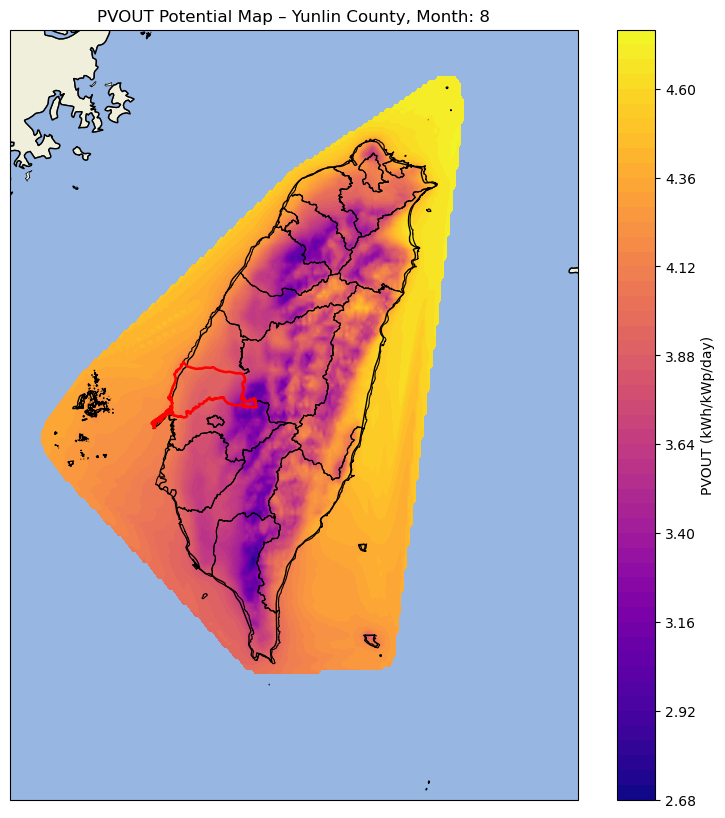

In [25]:
# ======================================
# Taiwan PVOUT contour + county boundaries (clean final version)
# ======================================

import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from shapely.geometry import Point
from scipy.interpolate import griddata

# --------------------------------------
# 0. User selection: target month and county
# --------------------------------------
target_month = 8  # integer (1-12)
target_county = '雲林縣'

# --------------------------------------
# 1. Load PVOUT data
# --------------------------------------
df = pd.read_csv(r"C:\Users\User\Downloads\taiwan_pvout_all_months.csv")
df.columns = df.columns.str.strip()

# Filter for target month
df_month = df[df["month"] == target_month][["lon", "lat", "pvout (kWh/kWp/day)"]].copy()
df_month = df_month.rename(columns={"pvout (kWh/kWp/day)": "pvout"})

# --------------------------------------
# 2. Interpolate data onto grid
# --------------------------------------
num_points = 200
lon_grid = np.linspace(119, 123, num_points)
lat_grid = np.linspace(21, 26, num_points)
lon2d, lat2d = np.meshgrid(lon_grid, lat_grid)

points = df_month[["lon", "lat"]].values
values = df_month["pvout"].values
grid_pvout = griddata(points, values, (lon2d, lat2d), method='cubic')

# --------------------------------------
# 3. Load county shapefile
# --------------------------------------
county_file_path = r"C:\Users\User\Downloads\直轄市、縣(市)界線1140318\COUNTY_MOI_1140318.shp"
gdf_county = gpd.read_file(county_file_path)

# Reproject to EPSG:4326 if needed
if gdf_county.crs.to_string() != 'EPSG:4326':
    gdf_county = gdf_county.to_crs(epsg=4326)

# Select target county geometry
county_row = gdf_county[gdf_county['COUNTYNAME'] == target_county]
if county_row.empty:
    raise ValueError("Target county not found in shapefile. Check spelling or field names.")

county_geom = county_row.geometry.iloc[0]
target_county_eng = county_row['COUNTYENG'].iloc[0]

# --------------------------------------
# 4. Plotting PVOUT contour + county boundaries
# --------------------------------------
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection=ccrs.Mercator())
ax.set_extent([119, 123, 21, 26], crs=ccrs.PlateCarree())

# Base map features
ax.coastlines(resolution='10m')
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, edgecolor='black')
ax.add_feature(cfeature.OCEAN)

# PVOUT contour
cf = ax.contourf(
    lon2d, lat2d, grid_pvout, 60,
    transform=ccrs.PlateCarree(), cmap="plasma"
)

# County boundaries overlay
for _, row in gdf_county.iterrows():
    geom = row.geometry
    ax.add_geometries([geom], crs=ccrs.PlateCarree(),
                      edgecolor='black', facecolor='none', linewidth=0.8)

# Highlight target county in red
ax.add_geometries([county_geom], crs=ccrs.PlateCarree(),
                  edgecolor='red', facecolor='none', linewidth=1.8)

# Colorbar and title
plt.colorbar(cf, ax=ax, orientation='vertical', label="PVOUT (kWh/kWp/day)")
plt.title(f"PVOUT Potential Map – {target_county_eng}, Month: {target_month}")
plt.show()


            County_EN  PVOUT_sum_kWh_kWp_day
16     Hualien County           20376.353599
3       Nantou County           16516.192326
15     Taitung County           15504.832425
14     Kaohsiung City           11616.344275
5     Pingtung County           10685.190781
1        Yilan County            9623.492003
9         Tainan City            9396.943279
19      Taichung City            9381.910087
8     New Taipei City            9072.982187
12      Chiayi County            7611.328233
20      Miaoli County            7299.130665
4       Yunlin County            6053.881401
21     Hsinchu County            5691.648665
2     Changhua County            5502.797525
10       Taoyuan City            5339.992151
7         Taipei City            1231.979524
6        Keelung City             647.274345
17      Penghu County             641.906073
18       Hsinchu City             588.596765
11        Chiayi City             268.527919
13      Kinmen County               0.000000
0   Liench

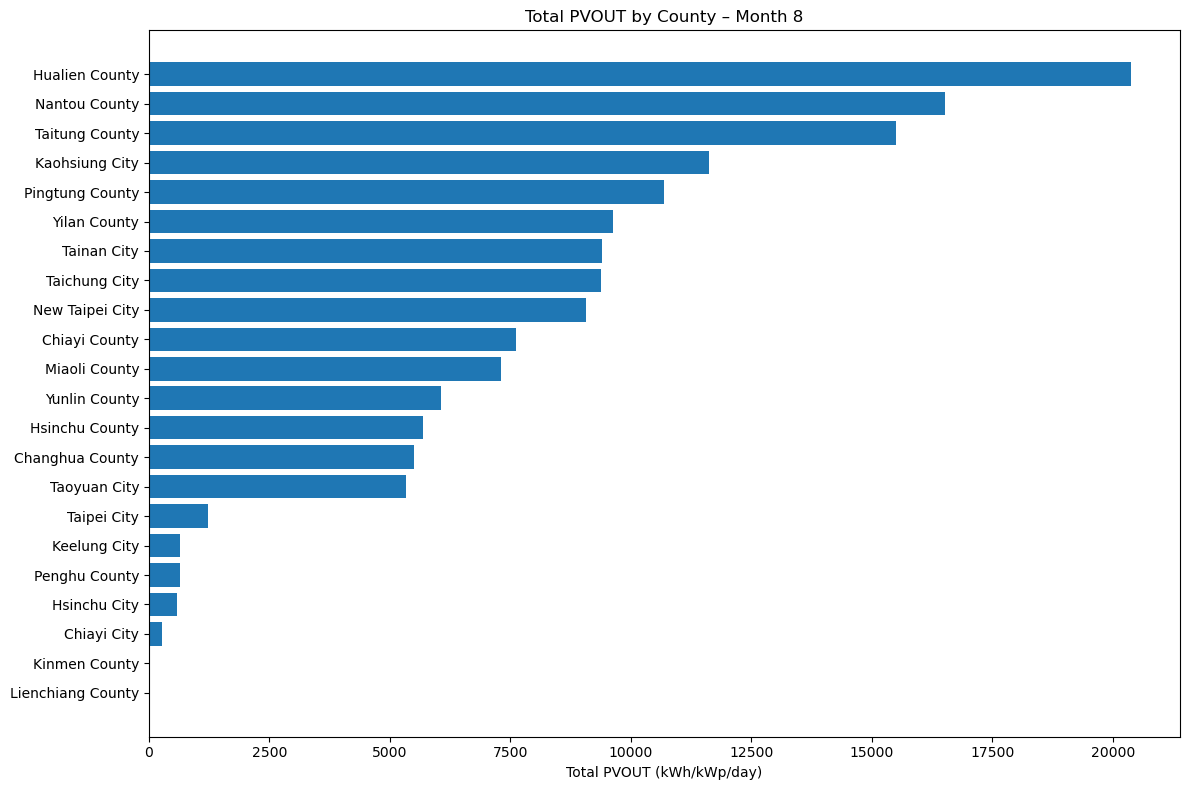

In [26]:
# ======================================
# Taiwan PVOUT total by county (bar chart)
# ======================================

import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
from scipy.interpolate import griddata

# --------------------------------------
# 0. User selection: target month
# --------------------------------------
target_month = 8  # integer (1-12)

# --------------------------------------
# 1. Load PVOUT data
# --------------------------------------
df = pd.read_csv(r"C:\Users\User\Downloads\taiwan_pvout_all_months.csv")
df.columns = df.columns.str.strip()

# Filter for target month
df_month = df[df["month"] == target_month][["lon", "lat", "pvout (kWh/kWp/day)"]].copy()
df_month = df_month.rename(columns={"pvout (kWh/kWp/day)": "pvout"})

# --------------------------------------
# 2. Interpolate data onto grid
# --------------------------------------
num_points = 500
lon_grid = np.linspace(119, 123, num_points)
lat_grid = np.linspace(21, 26, num_points)
lon2d, lat2d = np.meshgrid(lon_grid, lat_grid)

points = df_month[["lon", "lat"]].values
values = df_month["pvout"].values
grid_pvout = griddata(points, values, (lon2d, lat2d), method='cubic')

# Mask invalid values
grid_pvout = np.ma.masked_invalid(grid_pvout)

# --------------------------------------
# 3. Load county shapefile
# --------------------------------------
county_file_path = r"C:\Users\User\Downloads\直轄市、縣(市)界線1140318\COUNTY_MOI_1140318.shp"
gdf_county = gpd.read_file(county_file_path)

# Reproject to EPSG:4326 if needed
if gdf_county.crs.to_string() != 'EPSG:4326':
    gdf_county = gdf_county.to_crs(epsg=4326)

# --------------------------------------
# 4. Calculate total PVOUT within each county
# --------------------------------------
county_pv = []

for idx, row in gdf_county.iterrows():
    county_name_ch = row['COUNTYNAME']
    county_name_en = row['COUNTYENG']  # adjust if needed
    county_geom = row.geometry

    total_pvout = 0

    for i in range(len(lat_grid)):
        for j in range(len(lon_grid)):
            if grid_pvout[i,j] is np.ma.masked:
                continue
            point = Point(lon2d[i,j], lat2d[i,j])
            if county_geom.contains(point):
                pvout_value = grid_pvout[i,j]  # kWh/kWp/day
                total_pvout += pvout_value

    county_pv.append((county_name_en, total_pvout))

# --------------------------------------
# 5. Create DataFrame and plot bar chart
# --------------------------------------
pv_df = pd.DataFrame(county_pv, columns=['County_EN', 'PVOUT_sum_kWh_kWp_day'])
pv_df = pv_df.sort_values(by='PVOUT_sum_kWh_kWp_day', ascending=False)

# Print table for verification
print(pv_df)

# Plot
plt.figure(figsize=(12,8))
plt.barh(pv_df['County_EN'], pv_df['PVOUT_sum_kWh_kWp_day'])
plt.xlabel('Total PVOUT (kWh/kWp/day)')
plt.title(f'Total PVOUT by County – Month {target_month}')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


            County_EN    CMIP6_PV_MW  PVOUT_kWh_kWp_day
16     Hualien County  748847.385713       22510.381727
3       Nantou County  557382.297888       18093.861415
15     Taitung County  524771.197502       17302.214838
5     Pingtung County  419207.268659       12028.753848
14     Kaohsiung City  398470.819340       13007.759913
9         Tainan City  386071.292920       10269.008053
8     New Taipei City  382394.653777        9769.400989
19      Taichung City  360171.541359       10286.912565
1        Yilan County  349154.632609       10525.952276
20      Miaoli County  316042.052080        8015.191422
12      Chiayi County  310574.925792        8335.287960
4       Yunlin County  263404.950126        6536.082173
2     Changhua County  237848.302752        5902.045214
21     Hsinchu County  232914.198812        6127.636396
10       Taoyuan City  209403.009146        5727.412415
7         Taipei City   53272.164207        1312.739228
6        Keelung City   28191.594215         701

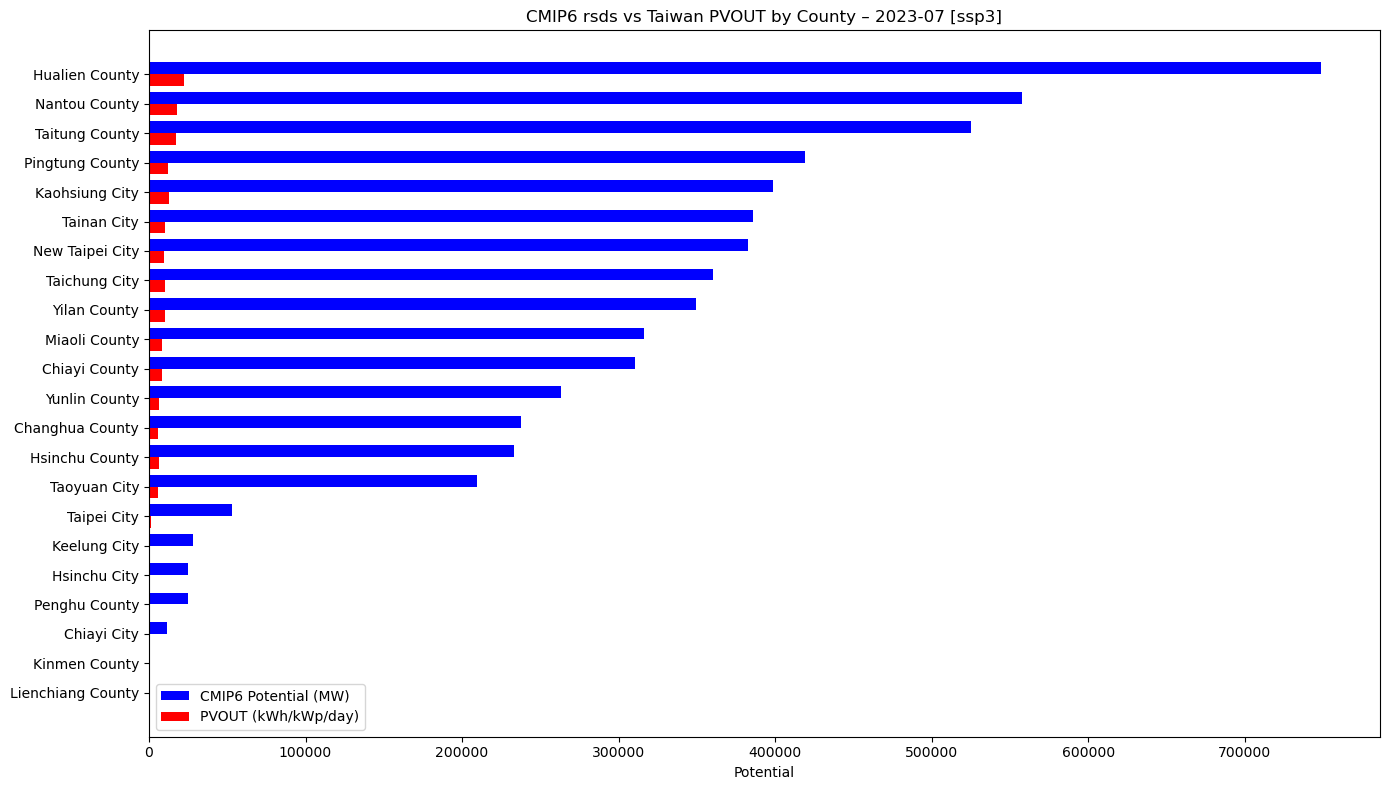

In [ ]:
# ======================================
# CMIP6 rsds vs Taiwan PVOUT comparison by county (integrated bar chart)
# ======================================

import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
from pyproj import Geod
from scipy.interpolate import griddata
import numpy.ma as ma

# --------------------------------------
# 0. User selection
# --------------------------------------
ssp_target = 'ssp3'  # choose from 'ssp2', 'ssp3', 'ssp5'
target_month_str = '2023-02'
target_month_num = int(target_month_str.split('-')[1])

# Map to column name in CMIP6 dataset
ssp_map = {
    'ssp2': 'rsds_ssp2',
    'ssp3': 'rsds_ssp3',
    'ssp5': 'rsds_ssp5'
}
rsds_col = ssp_map[ssp_target]

# --------------------------------------
# 1. Load CMIP6 data
# --------------------------------------
df_cmip6 = pd.read_csv(r"C:\Users\User\Downloads\cmip6_rsds_cnrmfull.csv")
df_cmip6.columns = df_cmip6.columns.str.strip()
df_cmip6["time"] = pd.to_datetime(df_cmip6["time"])

# Filter for target month
df_cmip6_month = df_cmip6[df_cmip6["time"].dt.strftime("%Y-%m") == target_month_str][["lon", "lat", rsds_col]].copy()
df_cmip6_month = df_cmip6_month.rename(columns={rsds_col: "rsds"})

# Interpolate onto grid
num_points = 500
lon_grid = np.linspace(119, 123, num_points)
lat_grid = np.linspace(21, 26, num_points)
lon2d, lat2d = np.meshgrid(lon_grid, lat_grid)

points = df_cmip6_month[["lon", "lat"]].values
values = df_cmip6_month["rsds"].values
grid_rsds = griddata(points, values, (lon2d, lat2d), method='cubic')
grid_rsds = ma.masked_invalid(grid_rsds)

# Calculate cell areas
geod = Geod(ellps="WGS84")
cell_areas = np.zeros(lon2d.shape)
for i in range(len(lat_grid)-1):
    for j in range(len(lon_grid)-1):
        lons = [lon2d[i,j], lon2d[i,j+1], lon2d[i+1,j+1], lon2d[i+1,j]]
        lats = [lat2d[i,j], lat2d[i,j+1], lat2d[i+1,j+1], lat2d[i+1,j]]
        poly_area, _ = geod.polygon_area_perimeter(lons, lats)
        cell_areas[i,j] = abs(poly_area)  # m²

# --------------------------------------
# 2. Load Taiwan PVOUT data
# --------------------------------------
df_pvout = pd.read_csv(r"C:\Users\User\Downloads\taiwan_pvout_all_months.csv")
df_pvout.columns = df_pvout.columns.str.strip()
df_pvout_month = df_pvout[df_pvout["month"] == target_month_num][["lon", "lat", "pvout (kWh/kWp/day)"]].copy()
df_pvout_month = df_pvout_month.rename(columns={"pvout (kWh/kWp/day)": "pvout"})

# Interpolate onto same grid
points_pv = df_pvout_month[["lon", "lat"]].values
values_pv = df_pvout_month["pvout"].values
grid_pvout = griddata(points_pv, values_pv, (lon2d, lat2d), method='cubic')
grid_pvout = ma.masked_invalid(grid_pvout)

# --------------------------------------
# 3. Load county shapefile
# --------------------------------------
county_file_path = r"C:\Users\User\Downloads\直轄市、縣(市)界線1140318\COUNTY_MOI_1140318.shp"
gdf_county = gpd.read_file(county_file_path)
if gdf_county.crs.to_string() != 'EPSG:4326':
    gdf_county = gdf_county.to_crs(epsg=4326)

# --------------------------------------
# 4. Calculate total CMIP6 rsds and PVOUT within each county
# --------------------------------------
efficiency = 0.699
panel_ratio = 0.3

county_stats = []

for idx, row in gdf_county.iterrows():
    county_name_en = row['COUNTYENG']
    county_geom = row.geometry

    total_rsds = 0
    total_pvout = 0

    for i in range(len(lat_grid)):
        for j in range(len(lon_grid)):
            point = Point(lon2d[i,j], lat2d[i,j])
            if county_geom.contains(point):
                # CMIP6 rsds potential (W/m² * m² * eff * ratio -> W)
                if grid_rsds[i,j] is not ma.masked:
                    rsds = grid_rsds[i,j]
                    area = cell_areas[i,j]
                    potential = rsds * area * efficiency * panel_ratio
                    total_rsds += potential / 1e6  # convert to MW

                # PVOUT sum
                if grid_pvout[i,j] is not ma.masked:
                    pvout = grid_pvout[i,j]
                    total_pvout += pvout  # sum of kWh/kWp/day

    county_stats.append((county_name_en, total_rsds, total_pvout))

# --------------------------------------
# 5. Create DataFrame and plot bar chart
# --------------------------------------
df_stats = pd.DataFrame(county_stats, columns=['County_EN', 'CMIP6_PV_MW', 'PVOUT_kWh_kWp_day'])
df_stats = df_stats.sort_values(by='CMIP6_PV_MW', ascending=False)

print(df_stats)

# Plot comparison bar chart
x = np.arange(len(df_stats))
width = 0.4

plt.figure(figsize=(14,8))
plt.barh(x - width/2, df_stats['CMIP6_PV_MW'], height=width, color='blue', label='CMIP6 Potential (MW)')
plt.barh(x + width/2, df_stats['PVOUT_kWh_kWp_day'], height=width, color='red', label='PVOUT (kWh/kWp/day)')

plt.yticks(x, df_stats['County_EN'])
plt.xlabel('Potential')
plt.title(f'CMIP6 rsds vs Taiwan PVOUT by County – {target_month_str} [{ssp_target}]')
plt.legend()
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


            County_EN  CMIP6_kWh_kWp_day  PVOUT_kWh_kWp_day
18       Hsinchu City           4.010172           3.842776
2     Changhua County           3.984388           4.428429
4       Yunlin County           3.976784           4.307207
17      Penghu County           3.971472           3.843980
11        Chiayi City           3.930981           4.159988
5     Pingtung County           3.917660           3.568420
20      Miaoli County           3.867359           3.922444
9         Tainan City           3.867348           4.221282
12      Chiayi County           3.746558           3.960779
19      Taichung City           3.678844           4.226719
15     Taitung County           3.660558           3.353767
21     Hsinchu County           3.508687           3.686535
10       Taoyuan City           3.503736           3.312701
14     Kaohsiung City           3.474069           3.919401
6        Keelung City           3.417155           2.198730
7         Taipei City           3.407746

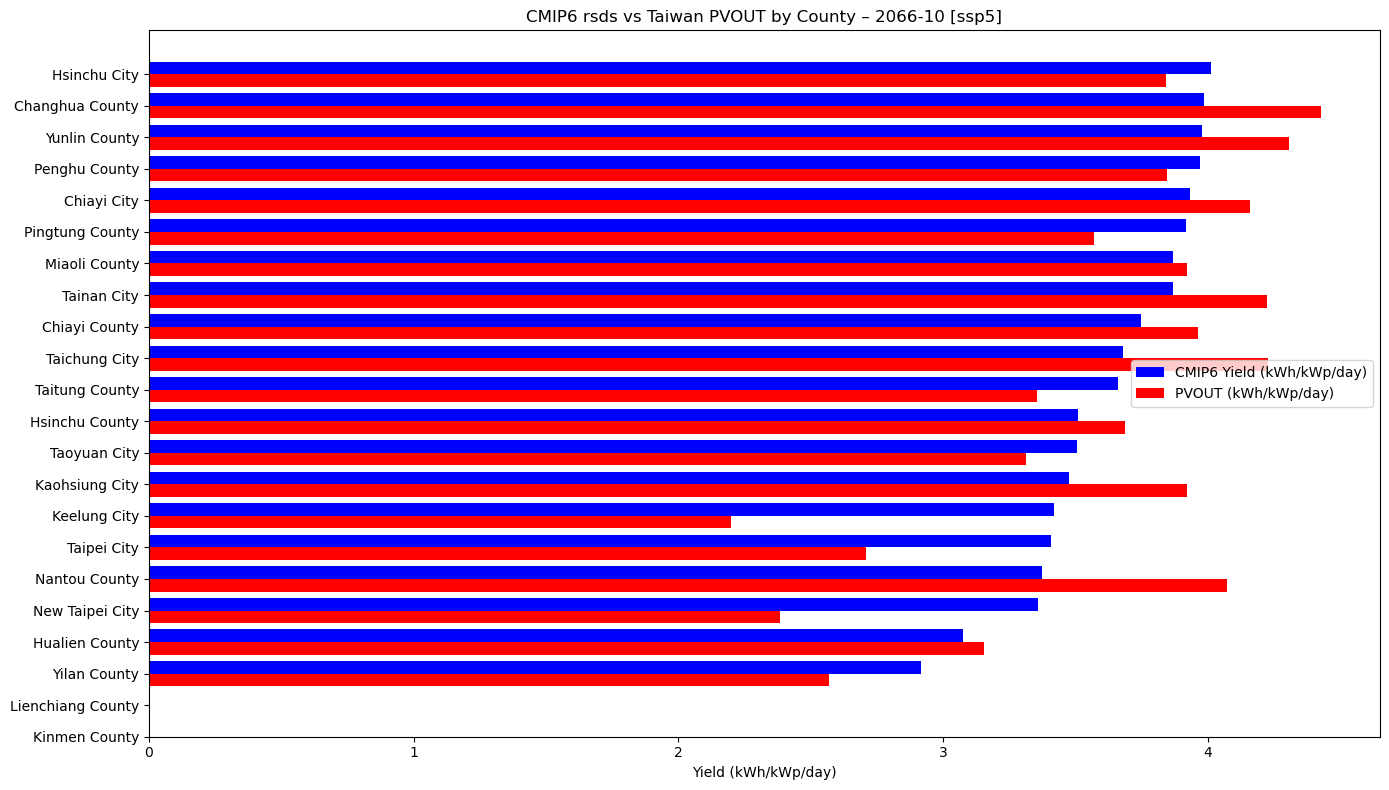

In [50]:
# ======================================
# CMIP6 rsds vs Taiwan PVOUT comparison by county (integrated bar chart)
# ======================================

import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
from pyproj import Geod
from scipy.interpolate import griddata
import numpy.ma as ma

# --------------------------------------
# 0. User selection
# --------------------------------------
ssp_target = 'ssp5'  # choose from 'ssp2', 'ssp3', 'ssp5'
target_month_str = '2066-10'
target_month_num = int(target_month_str.split('-')[1])

# ======================================
# Adjustable constants
# ======================================

module_efficiency = 0.699  # typical PV module efficiency (e.g. 0.18-0.22)
performance_ratio = 1  # system PR (e.g. 0.75-0.85)
num_points = 200        # grid resolution for interpolation (increase if needed)

# --------------------------------------
# 1. Load CMIP6 data
# --------------------------------------
df_cmip6 = pd.read_csv(r"C:\Users\User\Downloads\cmip6_rsds_cnrmfull.csv")
df_cmip6.columns = df_cmip6.columns.str.strip()
df_cmip6["time"] = pd.to_datetime(df_cmip6["time"])

# Map to column name in CMIP6 dataset
ssp_map = {'ssp2': 'rsds_ssp2', 'ssp3': 'rsds_ssp3', 'ssp5': 'rsds_ssp5'}
rsds_col = ssp_map[ssp_target]

# Filter for target month
df_cmip6_month = df_cmip6[df_cmip6["time"].dt.strftime("%Y-%m") == target_month_str][["lon", "lat", rsds_col]].copy()
df_cmip6_month = df_cmip6_month.rename(columns={rsds_col: "rsds"})

# Interpolate onto grid
lon_grid = np.linspace(119, 123, num_points)
lat_grid = np.linspace(21, 26, num_points)
lon2d, lat2d = np.meshgrid(lon_grid, lat_grid)

points = df_cmip6_month[["lon", "lat"]].values
values = df_cmip6_month["rsds"].values
grid_rsds = griddata(points, values, (lon2d, lat2d), method='cubic')
grid_rsds = ma.masked_invalid(grid_rsds)

# Calculate cell areas for area-weighted average
geod = Geod(ellps="WGS84")
cell_areas = np.zeros(lon2d.shape)
for i in range(len(lat_grid)-1):
    for j in range(len(lon_grid)-1):
        lons = [lon2d[i,j], lon2d[i,j+1], lon2d[i+1,j+1], lon2d[i+1,j]]
        lats = [lat2d[i,j], lat2d[i,j+1], lat2d[i+1,j+1], lat2d[i+1,j]]
        poly_area, _ = geod.polygon_area_perimeter(lons, lats)
        cell_areas[i,j] = abs(poly_area)  # in m²

# --------------------------------------
# 2. Load Taiwan PVOUT data
# --------------------------------------
df_pvout = pd.read_csv(r"C:\Users\User\Downloads\taiwan_pvout_all_months.csv")
df_pvout.columns = df_pvout.columns.str.strip()
df_pvout_month = df_pvout[df_pvout["month"] == target_month_num][["lon", "lat", "pvout (kWh/kWp/day)"]].copy()
df_pvout_month = df_pvout_month.rename(columns={"pvout (kWh/kWp/day)": "pvout"})

# Interpolate onto same grid
points_pv = df_pvout_month[["lon", "lat"]].values
values_pv = df_pvout_month["pvout"].values
grid_pvout = griddata(points_pv, values_pv, (lon2d, lat2d), method='cubic')
grid_pvout = ma.masked_invalid(grid_pvout)

# --------------------------------------
# 3. Load county shapefile
# --------------------------------------
county_file_path = r"C:\Users\User\Downloads\直轄市、縣(市)界線1140318\COUNTY_MOI_1140318.shp"
gdf_county = gpd.read_file(county_file_path)
if gdf_county.crs.to_string() != 'EPSG:4326':
    gdf_county = gdf_county.to_crs(epsg=4326)

# --------------------------------------
# 4. Calculate area-weighted CMIP6 yield and PVOUT yield within each county
# --------------------------------------
county_stats = []

for idx, row in gdf_county.iterrows():
    county_name_en = row['COUNTYENG']
    county_geom = row.geometry

    weighted_rsds_yield_sum = 0
    weighted_pvout_sum = 0
    total_area = 0

    for i in range(len(lat_grid)):
        for j in range(len(lon_grid)):
            point = Point(lon2d[i,j], lat2d[i,j])
            if county_geom.contains(point):
                area = cell_areas[i,j]

                if grid_rsds[i,j] is not ma.masked:
                    rsds_w_m2 = grid_rsds[i,j]

                    # Convert W/m² to kWh/m²/day (monthly daily mean × 24h)
                    rsds_kWh_m2_day = rsds_w_m2 * 24 / 1000

                    # Convert to kWh/kWp/day using module efficiency and PR
                    rsds_kWh_kWp_day = rsds_kWh_m2_day * module_efficiency * performance_ratio

                    weighted_rsds_yield_sum += rsds_kWh_kWp_day * area
                    total_area += area

                if grid_pvout[i,j] is not ma.masked:
                    pvout = grid_pvout[i,j]
                    weighted_pvout_sum += pvout * area

    # Calculate area-weighted averages
    if total_area > 0:
        avg_rsds_yield = weighted_rsds_yield_sum / total_area
        avg_pvout = weighted_pvout_sum / total_area
    else:
        avg_rsds_yield = np.nan
        avg_pvout = np.nan

    county_stats.append((county_name_en, avg_rsds_yield, avg_pvout))

# --------------------------------------
# 5. Create DataFrame and plot bar chart
# --------------------------------------
df_stats = pd.DataFrame(county_stats, columns=['County_EN', 'CMIP6_kWh_kWp_day', 'PVOUT_kWh_kWp_day'])
df_stats = df_stats.sort_values(by='CMIP6_kWh_kWp_day', ascending=False)

print(df_stats)

# Plot comparison bar chart
x = np.arange(len(df_stats))
width = 0.4

plt.figure(figsize=(14,8))
plt.barh(x - width/2, df_stats['CMIP6_kWh_kWp_day'], height=width, color='blue', label='CMIP6 Yield (kWh/kWp/day)')
plt.barh(x + width/2, df_stats['PVOUT_kWh_kWp_day'], height=width, color='red', label='PVOUT (kWh/kWp/day)')

plt.yticks(x, df_stats['County_EN'])
plt.xlabel('Yield (kWh/kWp/day)')
plt.title(f'CMIP6 rsds vs Taiwan PVOUT by County – {target_month_str} [{ssp_target}]')
plt.legend()
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()
